In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import time
import scipy.stats as stats
from scipy.stats import norm
from datetime import datetime

np.random.seed(1)

In [2]:
def get_stock_prices(symbol):
    import requests
    import datetime

    # Set API Key
    API_KEY = "CPH5HXXLYYVHFQ2Z"

    #symbol = "AAPL"

    # Calculate date range for the last 365 days
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=365)

    # API endpoint for Alpha Vantage
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&outputsize=full"

    # Make API request
    response = requests.get(url)
    data = response.json()

    # Extract stock prices for the last 365 days
    prices = []
    for date in data['Time Series (Daily)']:
        date_obj = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        if start_date <= date_obj <= end_date:
            prices.append({
                "date": date,
                "open": data["Time Series (Daily)"][date]["1. open"],
                "high": data["Time Series (Daily)"][date]["2. high"],
                "low": data["Time Series (Daily)"][date]["3. low"],
                "close": data["Time Series (Daily)"][date]["4. close"],
                "volume": data["Time Series (Daily)"][date]["5. volume"],
            })

    return prices       


In [3]:
brk_prices =   get_stock_prices("BRK.B") 

# Convert String Results to float array
brk = np.squeeze([float(brk_prices[i]['close']) for i in range(0, len(brk_prices))])
brk

array([324.33, 323.82, 323.09, 324.63, 323.79, 319.74, 318.05, 314.55,
       313.7 , 312.62, 312.51, 310.39, 309.07, 310.31, 308.77, 305.08,
       305.3 , 302.32, 302.14, 298.92, 298.37, 299.73, 303.85, 301.06,
       293.51, 302.01, 297.88, 305.33, 302.88, 303.63, 304.82, 311.37,
       311.12, 316.97, 312.45, 307.75, 304.62, 305.18, 304.66, 304.02,
       303.07, 303.16, 302.72, 308.24, 308.18, 309.63, 310.79, 313.74,
       309.89, 307.21, 308.48, 312.97, 308.43, 308.51, 311.86, 310.57,
       311.52, 307.33, 309.17, 310.95, 311.9 , 311.3 , 310.42, 309.87,
       305.23, 308.3 , 314.86, 317.64, 318.93, 320.37, 316.35, 315.53,
       318.69, 312.9 , 314.55, 309.91, 308.9 , 309.06, 303.43, 305.55,
       306.49, 302.69, 307.82, 302.  , 300.03, 300.  , 301.91, 309.29,
       312.33, 311.45, 306.39, 305.99, 305.82, 307.78, 310.57, 316.15,
       315.84, 318.6 , 315.13, 313.27, 317.43, 316.18, 315.76, 311.2 ,
       310.76, 307.44, 308.76, 309.98, 308.91, 309.72, 303.2 , 288.65,
      

In [4]:
import pandas as pd


# Calculating Historical 90 day volatility
def calc_volatility(prices, window=90):
    actualdf = pd.DataFrame({'prices':brk})

    #Calcuate Daily Returns
    #actualdf['Returns'] = actualdf['prices'].pct_change()
    actualdf['Returns'] = np.log(actualdf['prices']/actualdf['prices'].shift(1))

    window_size = window
    actualdf['Volatility'] = actualdf['Returns'].rolling(window_size).std() * np.sqrt(252)#window_size)
    
    return actualdf['Volatility'].mean(), actualdf

vol, actualdf = calc_volatility(brk)

print('Volatility = ' ,vol)

Volatility =  0.2242508596964469


## Calculate Drift 
To calculate the continuously compounded returns (drift), use the np.log() function to calculate the natural logarithm of the ratio of each stock price to the previous stock price. Slice the Ss array to exclude the first element, since there is no previous price to calculate returns from.

Then find the mean of the continuously compounded returns using the np.mean() function.

To calculate the stock price drift,  add the mean of the continuously compounded returns to half the variance of the returns, which is multiplied by the time increment. In this case, we assume a time increment of 1 day.

In [5]:
def calculate_drift(prices):
    log_returns = np.diff(np.log(prices))
    drift = log_returns.mean() + (0.5 * log_returns.var())
    return drift

# Calc drift function
drift = calculate_drift(brk)*252 #252 trading days
print('Drift =', drift)

Drift = 0.06252140019824377


## European Option Pricing with Black Scholes 

The Black-Scholes model is a mathematical model used to calculate the theoretical value of European call and put options, under the assumption that the underlying stock price follows geometric Brownian motion with constant volatility and that there are no transaction costs or taxes.

The model takes into account five parameters: the current stock price (S), the strike price (K), the time to expiration (T), the risk-free interest rate (r), and the volatility of the stock price (σ). Using these parameters, the Black-Scholes model provides an estimate of the fair price of a call or put option, which is the amount that the option buyer should pay to the option seller to enter into the contract.

The Black-Scholes equation is as follows…

$$
C(S_t, T-t) = S_t \Phi(\frac{ln(\frac{S_t}{B(t,T)K}) + \frac{1}{2}\sigma^2(T-t)} {\sigma\sqrt{(T-t)}}) - B(t,T)X\Phi(\frac{ln(\frac{S_t}{B(t,T)K}) + \frac{1}{2}\sigma^2(T-t)} {\sigma\sqrt{(T-t)}})
$$
<br />

where: <br />
$S_t$ — Stock price at time t <br /> 
$K$ — Strike price of the option <br /> 
$\sigma$ — Volatility term <br /> 
$Phi$ — Cumulative normal distribution function<br /> 
$T$ — Time until maturity<br /> 
$t$ — Current point in time<br /> 
$B(t,T)$ — Continuous discount factor. Or the risk free rate r * the time till expiration (T-t)<br /> 


References: 
https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9
https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model Alternative Formulation

In [6]:


class European:

    def call_price(
        self, S, vol, K,
        T, r
            ):
        b = math.exp(-r*T)
        d1 = math.log(S/(b*K)) + .5*(vol**2)*T
        d1 = d1/(vol*(T**.5))
        z1 = norm.cdf(d1)
        z1 = z1*S
        d2 = math.log(S/(b*K)) - .5*(vol**2)*T
        d2 = d2/(vol*(T**.5))
        z2 = norm.cdf(d2)
        z2 = b*K*z2
        return z1 - z2

    def put_price(
        self, S, vol, K,
        T, r
            ):
        b = math.exp(-r*T)
        d1 = math.log((b*K)/S) + .5*(vol**2)*T
        d1 = d1/(vol*(T**.5))
        z1 = norm.cdf(d1)
        z1 = b*K*z1
        d2 = math.log((b*K)/S) - .5*(vol**2)*T
        d2 = d2/(vol*(T**.5))
        z2 = norm.cdf(d2)
        z2 = S*z2
        return z1 - z2

    def __init__(
        self, S, vol, K,
        T, r
            ):
        self.S = S # Stock Price
        self.vol = vol  # Stock Volatility
        self.K = K  # Strike Price
        self.T = T  # Time to expiration
        self.r = r  # risk free rate
        self.call = self.call_price(S, vol, K, T, r)
        self.put = self.put_price(S, vol, K, T, r)
        



In [7]:

# Option parameters
S = brk[1]
vol = vol
K = 300
r = .0339       #https://ycharts.com/indicators/10_year_treasury_rate
T = (datetime(2024,1,19) - datetime.today()).days/365 

option_brk = European(S, vol, K, T, r)



In [8]:
option_brk.call

42.436511512418576

In [9]:
option_brk.put

11.21421474419681

## American option pricing with binomial model

References:
https://quantpy.com.au/binomial-tree-model/american-put-options-with-the-binomial-asset-pricing-model/
http://www.quantschool.com/home/quant-finance/binomial-method

In [10]:
class American:

    def call_price(
        self, S, vol, drift, K, T, r, N = 252 # Trading days in a year
            ):
        N = math.floor(T*N) # Taking number of binomial steps as number of days to expiration
        dt = T/N
        u = np.exp(vol * np.sqrt(dt))  # Up jump factor
        d = 1/u
        q = (np.exp(r*dt) - d)/(u-d) #Up down probability
        disc = np.exp(-r*dt)
        # Initialising stock prices at maturity
        St = np.zeros(N+1)
        St = S * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
        # Calculating all payoffs
        C = np.zeros(N+1)
        C = np.maximum(0, St - K) # Payoff at maturity

        for i in np.arange(N-1,-1,-1):
          St = S * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
          C[:i+1] = disc * ( q*C[1:i+2] + (1-q)*C[0:i+1] )
          C = C[:-1]
          C = np.maximum(C, St - K)
                
        return C[0]

    def put_price(
        self, S, vol, drift, K, T, r, N = 252 # Trading days in a year
            ):
        N = math.floor(T*N) # Number of binomial steps
        dt = T/N
        u = np.exp(vol * np.sqrt(dt))  # Up jump factor
        d = 1/u
        q = (np.exp(r*dt) - d)/(u-d)
        disc = np.exp(-r*dt)
        # Initialising stock prices at maturity
        St = np.zeros(N+1)
        St = S * d**(np.arange(N,-1,-1)) * u**(np.arange(0,N+1,1))
        # Calculating all payoffs
        C = np.zeros(N+1)
        C = np.maximum(0, K - St) # Payoff at maturity

        for i in np.arange(N-1,-1,-1):
          St = S * d**(np.arange(i,-1,-1)) * u**(np.arange(0,i+1,1))
          C[:i+1] = disc * ( q*C[1:i+2] + (1-q)*C[0:i+1] )
          C = C[:-1]
          C = np.maximum(C, K - St)
                
        return C[0]

    

    def __init__(
        self, S, vol, drift, K,
        T, r
            ):
        self.S = S
        self.vol = vol
        self.drift = drift
        self.K = K
        self.T = T
        self.r = r
        self.call = self.call_price(S, vol, drift, K, T, r)
        self.put = self.put_price(S, vol, drift, K, T, r)

In [11]:

# Option parameters
S = brk[1]
vol = vol
drift = drift
K = 300
r = .0339       #https://ycharts.com/indicators/10_year_treasury_rate
T = (datetime(2024,1,19) - datetime.today()).days/365

option_brk = American(S, vol, drift, K, T, r)



In [12]:
option_brk.call

42.44254344971265

In [13]:
option_brk.put

11.552054822765394

# Monte Carlo Simulation

## 1. Brownian Motion

Generate a sequence of n $Y_i$'s with mean 0, variance 1

Can construct GBM as follows:

$W(\frac{i}{n})=W(\frac{i-1}{n}) + \frac{Y_i}{\sqrt{n}}$

In [14]:
m = 100 # Number of replications
n = 100 # Number of RVs Y generated for each process
Y = np.random.normal(size=(m,n))
W = np.zeros((m,n)) 

# (Keep W(0) <- 0)

for i in range(m):
    for j in range(1,n):
        W[i,j] = W[i,j-1] + Y[i,j]/(n**0.5)
        

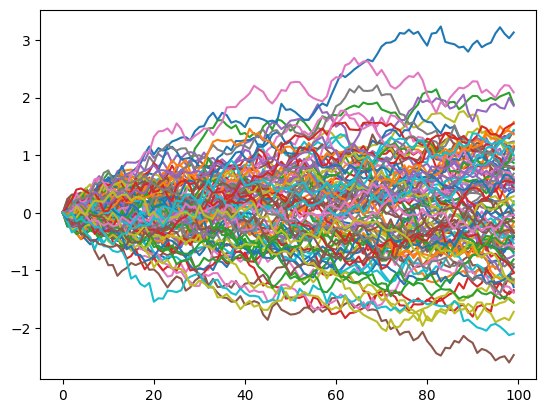

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(W.T)
plt.show()
plt.clf()

## Geometric Brownian Motion

Geometric Brownian motion can be defined as the following continuous stochastic process:

$ S(t) = S(0)\exp\{(\mu-\frac{\sigma^2}{2} + \sigma W(t)\} $

In [16]:
#Set mu = 1.0
#Set simga = 1
# S[0] is the initial price

In [17]:
### Set simulation constants and initialize m*n array
START_PRICE = 100
mu = 0.1
sigma2 = 1
S = np.zeros((m,n))
S[:,0] = START_PRICE


for i in range(m):
    for j in range(1,n):
        S[i,j] = START_PRICE*(np.exp((mu-sigma2/2)*j/n +
                     sigma2**0.5*W[i,j] ))

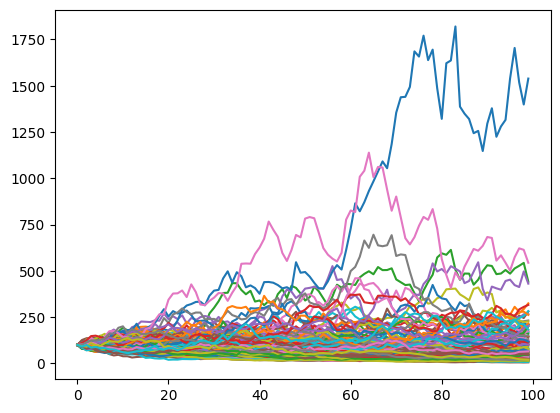

In [18]:
plt.clf()
plt.plot(S.T)
plt.show()

# Option Pricing using Monte Carlo Simulation

Reference: https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9

In [19]:
class GeometricBrownianMotion:

    def simulate_paths(self):
        N = math.floor(self.T*252) # Taking number of steps as number of trading days to expiration
        for i in range(0, N):
            dWt = np.random.normal(0, math.sqrt(self.dt))  # Brownian motion
            dYt = self.drift*self.dt + self.volatility*dWt  # Change in price
            self.current_price = self.current_price*(1+dYt)  # Add the change to the current price
            self.prices.append(self.current_price)  # Append new price to series
        self.prices = np.array(self.prices)

    def __init__(self, initial_price, drift, volatility, T, dt = 1/252):
        self.current_price = initial_price
        self.initial_price = initial_price
        self.drift = drift
        self.volatility = volatility
        self.dt = dt
        self.T = T
        self.prices = []
        self.simulate_paths()
   

    

In [20]:
# Pricing European Options
class European_mcs:

    def get_paths(self):
      for i in range(0, M):
        self.price_paths.append(GeometricBrownianMotion(self.S, drift, self.vol,self.T).prices)
      self.price_paths = np.array(self.price_paths)
      # Plot the set of generated sample paths
      for price_path in self.price_paths:
        plt.plot(price_path)
      plt.show()

    def call_price(
        self, S, vol, K,
        T, r,call_payoffs=[]
            ):
      for price_path in self.price_paths:
        call_payoff = ((price_path[-1]) - K)/(1 + r)  if (price_path[-1]) > K else 0
        call_payoffs.append(call_payoff)
      return np.average(call_payoffs)

    def put_price(
        self, S, vol, K,
        T, r,put_payoffs=[]
            ):
      for price_path in self.price_paths:
        put_payoff = (K -  (price_path[-1]))/(1 + r) if (price_path[-1]) < K else 0
        put_payoffs.append(put_payoff)
      return np.average(put_payoffs)

    def __init__(self, M, S, vol, drift, K,T, r):
      self.M = M
      self.S = S
      self.vol = vol
      self.drift = drift
      self.K = K
      self.T = T
      self.r = r
      self.price_paths=[]
      self.get_paths()
      self.call = self.call_price(S, vol, K, T, r)
      self.put = self.put_price(S, vol, K, T, r)
  

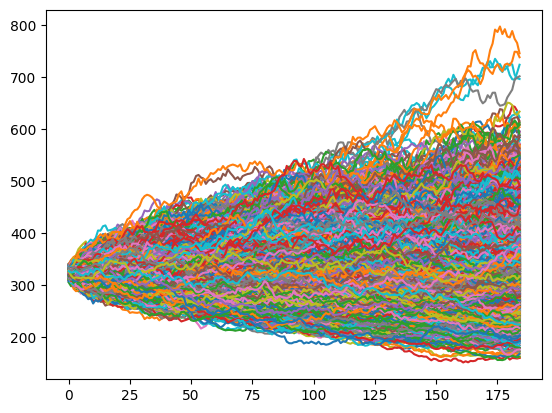

In [21]:
  # Option parameters
S = brk[1]
vol = vol
drift = drift
K = 300 #Strike
r = .0358       #https://ycharts.com/indicators/10_year_treasury_rate
T = (datetime(2024,1,19) - datetime.today()).days/365 #(datetime(2024,1,19) - datetime.today()).days/365
M = int(1e4)
option_brk = European_mcs(M, S, vol, drift, K, T, r)



In [22]:
option_brk.call

46.78095403457172

In [23]:
option_brk.put

9.163010935414729

## American option pricing using Least Squares Monte Carlo simlution

References:

https://medium.datadriveninvestor.com/a-complete-step-by-step-guide-for-pricing-american-option-712c84aa254e
https://subscription.packtpub.com/book/data/9781789618518/6/ch06lvl1sec37/pricing-american-options-with-least-squares-monte-carlo

In [24]:
#American option pricing using Least Squares Monte Carlo simlution

class American_mcs:

    def get_paths(self):
      for i in range(0, M):
        self.price_paths.append(GeometricBrownianMotion(self.S, drift, self.vol,self.T).prices)
      self.price_paths = np.array(self.price_paths)
      # Plot the set of generated sample paths
      for price_path in self.price_paths:
        plt.plot(price_path)
      plt.show()

    def call_price(
        self, S, vol, K, T, r, M
            ):
      
      N = math.floor(T*252) # Taking number of binomial steps as number of trading days to expiration
      dt = T/252
      df = np.exp(-r * dt)
      
      St = pd.DataFrame(data=self.price_paths, index=np.arange(1,M+1))
      payoff_matrix = np.maximum(St - K, 0)

      value_matrix = payoff_matrix.copy()
      value_matrix[:] = 0
      value_matrix.iloc[:, -1] = payoff_matrix.iloc[:, -1]

      for t in range(N - 2, 0 , -1):
        regression = np.polyfit(St.iloc[:, t], value_matrix.iloc[:, t + 1] *df, 5) # Using 5 as the degree of fit
        continuation_value = np.polyval(regression, St.iloc[:, t])
        value_matrix.iloc[:, t] = np.where(
            payoff_matrix.iloc[:, t] > continuation_value,
            payoff_matrix.iloc[:, t],
            value_matrix.iloc[:, t + 1] * df
        )
      option_premium = np.mean(value_matrix.iloc[:, 1] * df)

      return option_premium

      


    def put_price(
        self, S, vol, K, T, r, M
            ):
      N = math.floor(T*252) # Taking number of binomial steps as number of trading days to expiration
      dt = T/252
      df = np.exp(-r * dt)
      
      St = pd.DataFrame(data=self.price_paths, index=np.arange(1,M+1))
      payoff_matrix = np.maximum(K - St, 0)

      value_matrix = payoff_matrix.copy()
      value_matrix[:] = 0
      value_matrix.iloc[:, -1] = payoff_matrix.iloc[:, -1]

      for t in range(N - 2, 0 , -1):
        regression = np.polyfit(St.iloc[:, t], value_matrix.iloc[:, t + 1] *df, 5) # Using 5 as the degree of fit
        continuation_value = np.polyval(regression, St.iloc[:, t])
        value_matrix.iloc[:, t] = np.where(
            payoff_matrix.iloc[:, t] > continuation_value,
            payoff_matrix.iloc[:, t],
            value_matrix.iloc[:, t + 1] * df
        )
      option_premium = np.mean(value_matrix.iloc[:, 1] * df)

      return option_premium
      

  
    def __init__(self, M, S, vol, drift, K, T, r):
      self.M = M
      self.S = S
      self.vol = vol
      self.drift = drift
      self.K = K
      self.T = T
      self.r = r
      self.price_paths=[]
      self.get_paths()
      self.call = self.call_price(S, vol, K, T, r, M)
      self.put = self.put_price(S, vol, K, T, r, M)


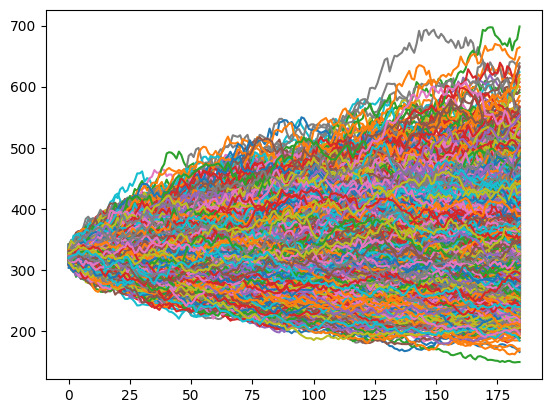

In [25]:
  # Option parameters
S = brk[1]
vol = vol
drift = drift
K = 300 #Strike
r = .0358       #https://ycharts.com/indicators/10_year_treasury_rate
T = (datetime(2024,1,19) - datetime.today()).days/365 #(datetime(2024,1,19) - datetime.today()).days/365
M = int(1e4)
option_brk = American_mcs(M, S, vol, drift, K, T, r)

In [26]:
option_brk.call

45.68839960986885

In [27]:
option_brk.put

9.596996452707067

# Monte Carlo Option Pricing with Variance reduction using Antithetic variates

In [28]:
class GBM_AntitheticVR:

    def simulate_paths(self):
        N = math.floor(self.T*252) # Taking number of steps as number of trading days to expiration
        for i in range(0, N):
            dWt = np.random.normal(0, math.sqrt(self.dt))  # Brownian motion
            dYt1 = self.drift*self.dt + self.volatility*dWt
            dYt2 = self.drift*self.dt - self.volatility*dWt  # Adding antithetic variate
            self.current_price1 = self.current_price1*(1+dYt1)  
            self.prices.append(self.current_price1)  
            self.current_price2 = self.current_price2*(1+dYt2)  
            self.prices.append(self.current_price2)  
        self.prices = np.array(self.prices)

    def __init__(self, initial_price, drift, volatility, T, dt = 1/252):
        self.current_price1 = initial_price
        self.current_price2 = initial_price
        self.initial_price = initial_price
        self.drift = drift
        self.volatility = volatility
        self.dt = dt
        self.T = T
        self.prices = []
        self.simulate_paths()

In [29]:
# Pricing European Options
class European_mcs_vr:

    def get_paths(self):
      for i in range(0, M):
        self.price_paths.append(GBM_AntitheticVR(self.S, drift, self.vol,self.T).prices)
      self.price_paths = np.array(self.price_paths)
      # Plot the set of generated sample paths
      for price_path in self.price_paths:
        plt.plot(price_path)
      plt.show()

    def call_price(
        self, S, vol, K,
        T, r,call_payoffs=[]
            ):
      for price_path in self.price_paths:
        call_payoff = ((price_path[-1]) - K)/(1 + r)  if (price_path[-1]) > K else 0
        call_payoffs.append(call_payoff)
      return np.average(call_payoffs)

    def put_price(
        self, S, vol, K,
        T, r,put_payoffs=[]
            ):
      for price_path in self.price_paths:
        put_payoff = (K -  (price_path[-1]))/(1 + r) if (price_path[-1]) < K else 0
        put_payoffs.append(put_payoff)
      return np.average(put_payoffs)

    def __init__(self, M, S, vol, drift, K,T, r):
      self.M = M
      self.S = S
      self.vol = vol
      self.drift = drift
      self.K = K
      self.T = T
      self.r = r
      self.price_paths=[]
      self.get_paths()
      self.call = self.call_price(S, vol, K, T, r)
      self.put = self.put_price(S, vol, K, T, r)
  

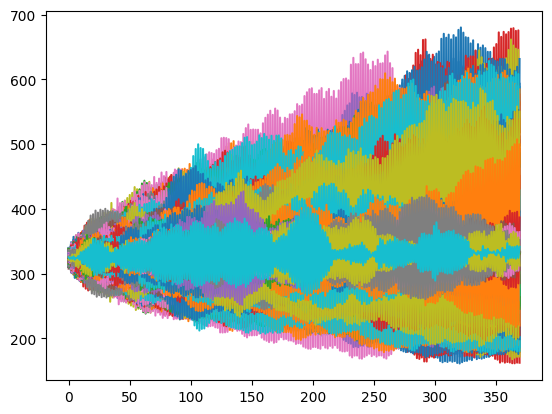

In [39]:
# Option parameters
S = brk[1]
vol = vol
drift = drift
K = 300 #Strike
r = .0358       #https://ycharts.com/indicators/10_year_treasury_rate
T = (datetime(2024,1,19) - datetime.today()).days/365 #(datetime(2024,1,19) - datetime.today()).days/365
M = int(1e4/2)
option_brk = European_mcs_vr(M, S, vol, drift, K, T, r)

In [40]:
option_brk.call

47.23989741666295

In [41]:
option_brk.put

9.372181724468112